## Preliminaries

In [237]:
import numpy as np
import numpyro
import numpyro.distributions as dist
from jax.numpy import DeviceArray
import jax.numpy as jnp
from jax import random
import pandas as pd
import matplotlib.pyplot as plt


In [238]:
%matplotlib inline
seed = 1
rng_key = random.PRNGKey(seed)

## Generate dummy data

In [239]:
# Generate items
# For now, items described by single attribute - quality
# Each item has a list price determined by that quality
def gen_items(num_items, rng_key):
    keys = random.split(rng_key,2)
    item_quality = dist.Uniform(1, 10).sample(keys[0], (num_items,))
    list_price = jnp.maximum(dist.Normal(item_quality, 1.0).sample(keys[1]),1.0) * 20
    #plt.scatter(item_quality, list_price)
    return item_quality, list_price

_ = gen_items(100, rng_key)

In [240]:
def lognormal_params(mu, sigma):
    loc = np.log(mu**2/np.sqrt(mu**2 + sigma**2))
    scale = np.sqrt(np.log(1 + sigma**2/mu**2))
    return loc, scale


def gen_cust(num_cust, rng_key):
    keys = random.split(rng_key,3)

    beta_quality_loc = dist.Uniform(5,10).sample(keys[0])
    beta_quality_scale = dist.Uniform(1,2).sample(keys[1])
    loc, scale = lognormal_params(beta_quality_loc, beta_quality_scale)
    beta_quality = dist.LogNormal(loc, scale).expand((num_cust,)).sample(keys[2])
    mean_beta_quality = jnp.mean(beta_quality)
    std_beta_quality = jnp.std(beta_quality)
    print('mean_beta_quality: ' + str(mean_beta_quality), 'std_beta_quality: ' + str(std_beta_quality))

    return beta_quality

_ = gen_cust(10, rng_key)

mean_beta_quality: 7.6662745 std_beta_quality: 0.94968593


In [241]:
def gen_sales(num_sales, rng_key):
    keys = random.split(rng_key,2)
    sales_wtp_bias = dist.Uniform(-0.2,0.1).expand((num_sales,)).sample(keys[0])
    sales_wtp_uncertainty = dist.Uniform(0.1,0.5).expand([num_sales,]).sample(keys[1])
    print('mean_wtp_bias: ' + str(jnp.mean(sales_wtp_bias)), 'std_wtp_bias: ' + str(jnp.std(sales_wtp_bias)))
    print('mean_wtp_uncertainty: ' + str(jnp.mean(sales_wtp_uncertainty)), 'std_wtp_uncertainty: ' + str(jnp.std(sales_wtp_uncertainty)))
    return sales_wtp_bias, sales_wtp_uncertainty

_ = gen_sales(20, rng_key)

mean_wtp_bias: -0.060042 std_wtp_bias: 0.083096355
mean_wtp_uncertainty: 0.34853464 std_wtp_uncertainty: 0.098519154


In [242]:
def gen_quotes(max_items_per_cust, num_cust, num_items, rng_key):
    keys = random.split(rng_key,3)
    concentration = jnp.full(max_items_per_cust, 5.0)
    item_probs = dist.Dirichlet(concentration).sample(keys[0])
    num_item_by_cust = dist.Categorical(item_probs).sample(keys[1], (num_cust,))
    #plt.hist(num_item_by_cust, bins=max_items_per_cust)

    customer_id_list = []
    customer_items_list = []
    key = keys[2]
    for customer, num_items_for_cust in enumerate(num_item_by_cust):
        customer_id_inc = [customer] * num_items_for_cust
        customer_items_inc = random.choice(key, num_items, (num_items_for_cust,), replace=True)
        key = random.split(key,1)[0]
        #customer_items_inc = torch.randperm(num_items)[:num_items_for_cust].tolist()
        customer_id_list.extend(customer_id_inc)
        customer_items_list.extend(customer_items_inc)
        
    customer_id = jnp.array(customer_id_list, dtype=jnp.int32)
    customer_items = jnp.array(customer_items_list, dtype=jnp.int32)
    #print(customer_id.shape, customer_items.shape)

    num_quotes = customer_items.shape[0]
    return customer_id, customer_items, num_quotes

_ = gen_quotes(5, 10, 20, rng_key)

In [243]:
def gen_negotiations(X, rng_key):

    keys = random.split(rng_key,1)

    x_salesperson = jnp.array(X['salesperson'])
    x_item_quality = jnp.array(X['item_quality'])
    x_list_price = jnp.array(X['list_price'])
    x_customer_id = jnp.array(X['customer'])
    x_item = jnp.array(X['item'])
    x_beta_quality = jnp.array(X['beta_quality'])
    x_sales_wtp_bias = jnp.array(X['sales_wtp_bias'])
    x_sales_wtp_uncertainty = jnp.array(X['sales_wtp_uncertainty'])

    num_quotes = len(X)

    y = {}
    key = keys[0]
    for q in range(num_quotes):
        c = x_customer_id[q]
        s = x_salesperson[q]
        i = x_item[q]
        wtp = jnp.minimum(x_item_quality[q] * x_beta_quality[q], x_list_price[q])
        est_wtp = jnp.minimum(dist.Normal(wtp*(1.0+x_sales_wtp_bias[q]), wtp*x_sales_wtp_uncertainty[q]).sample(key), x_list_price[q])
        key = random.split(key,1)[0]
        #print(wtp, x_list_price[q], est_wtp, wtp.dtype, est_wtp.dtype)
        if wtp >= x_list_price[q]:
            result = 1
            price = x_list_price[q]
        if wtp < est_wtp:
            result = 0
            price = np.nan
        else:
            result = 1
            price = ( est_wtp + wtp ) /2
        y[q] = {'result':result, 'price':price, 'wtp':wtp, 'est_wtp':est_wtp}

    return y


In [244]:
def sequential_idx(X):
    # map customer, item and salesperson ids to sequential versions of same for convenience later
    customer_map = {}
    for i, c in enumerate(X['customer'].unique()):
        customer_map[c] = i
    item_map = {}
    for i, item in enumerate(X['item'].unique()):
        item_map[item] = i
    salesperson_map = {}
    for i, s in enumerate(X['salesperson'].unique()):
        salesperson_map[s] = i

    X['customer'] = X['customer'].map(customer_map)
    X['item'] = X['item'].map(item_map)
    X['salesperson'] = X['salesperson'].map(salesperson_map)

    return X

In [245]:
# Generate customers
# Each customer has a view on the value of item quality which determines their willingness to pay

def gen_negs(rng_key):

    keys = random.split(rng_key,6)

    num_items = 50
    item_quality, list_price = gen_items(num_items, keys[0])
    
    num_cust = 200
    beta_quality = gen_cust(num_cust, keys[1])

    # Generate salespeople
    # Each salesperson has an ability to estimate the customers wtp subject to some bias and uncertainty
    num_sales = 10
    sales_wtp_bias, sales_wtp_uncertainty = gen_sales(num_sales, keys[2])

    # Generate quotes
    ## Each customer generates a number of quotes for items
    max_items_per_customer = 5
    customer_id, customer_items, num_quotes = gen_quotes(max_items_per_customer, num_cust, num_items, keys[3])

    ## Salespeople ramdomly assigned to quotes
    salesperson = random.choice(keys[4], num_sales, (num_quotes,), replace=True)

    # Negotiate quotes, get result and agreed price
    X = pd.DataFrame({'customer':customer_id, 'beta_quality':beta_quality[customer_id], 'item':customer_items, 'item_quality':item_quality[customer_items]
        , 'list_price':list_price[customer_items], 'salesperson':salesperson, 'sales_wtp_bias':sales_wtp_bias[salesperson], 'sales_wtp_uncertainty':sales_wtp_uncertainty[salesperson]})

    # map customer, item and salesperson ids to sequential versions of same for convenience later
    X = sequential_idx(X)

    y_dict = gen_negotiations(X, keys[5])
    y = pd.DataFrame.from_dict(y_dict, orient='index', dtype = 'float', columns=['result', 'price', 'wtp', 'est_wtp'])
    
    return pd.concat([X,y], axis=1)


df = gen_negs(rng_key)

mean_beta_quality: 8.3857 std_beta_quality: 1.2520736
mean_wtp_bias: -0.026670992 std_wtp_bias: 0.056275062
mean_wtp_uncertainty: 0.31436858 std_wtp_uncertainty: 0.10645751
result     float64
price      float64
wtp        float64
est_wtp    float64
dtype: object


In [246]:
df.describe(include='all')

,customer,beta_quality,item,item_quality,list_price,salesperson,sales_wtp_bias,sales_wtp_uncertainty,result,price,wtp,est_wtp
count,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,412.000000,210.000000,412.000000,412.000000
mean,86.121359,8.439120,23.883495,4.629865,93.709648,4.677184,-0.026393,0.312020,0.509709,33.217838,39.079423,38.007822
std,47.059830,1.181640,14.075950,2.193205,43.276104,2.922380,0.057136,0.106601,0.500514,17.704077,19.458007,24.473137
min,0.000000,5.277597,0.000000,1.230101,20.000000,0.000000,-0.118208,0.195662,0.000000,6.054184,9.558020,-18.662159
25%,47.000000,7.512908,13.000000,3.408390,60.799347,2.000000,-0.078682,0.220202,0.000000,21.112239,26.463047,19.443415
50%,86.500000,8.463624,23.000000,4.251019,91.694481,5.000000,-0.014974,0.230783,1.000000,29.272933,36.075436,35.264120
75%,126.250000,9.159924,36.000000,5.625066,115.870865,7.000000,0.018240,0.408138,1.000000,43.546630,50.184523,49.416731
max,166.000000,12.037019,49.000000,9.659722,190.128967,9.000000,0.057598,0.482419,1.000000,83.910187,102.453026,127.397949


In [247]:
df.sample(10)

,customer,beta_quality,item,item_quality,list_price,salesperson,sales_wtp_bias,sales_wtp_uncertainty,result,price,wtp,est_wtp
287,119,7.471033,16,1.512454,47.988338,8,-0.078682,0.408138,1.0,9.092390,11.299596,6.885184
29,14,8.117786,10,4.251019,91.245811,4,-0.044349,0.228962,0.0,NaN,34.508869,40.054661
163,70,10.039453,23,4.388145,66.762436,8,-0.078682,0.408138,1.0,39.335686,44.054573,34.616802
156,67,5.277597,11,4.317691,91.694481,9,0.022551,0.195662,0.0,NaN,22.787031,27.165630
230,98,8.582457,26,9.143119,176.813049,6,-0.118208,0.385435,1.0,66.053627,78.470421,53.636829
5,2,7.467395,5,4.146526,94.961060,3,0.016472,0.220202,0.0,NaN,30.963749,31.473337
70,34,9.450624,40,8.637453,187.143326,7,0.018240,0.230783,0.0,NaN,81.629326,101.010880
368,150,7.419269,9,3.597047,63.239742,9,0.022551,0.195662,1.0,26.043095,26.687458,25.398729
375,151,6.996219,43,3.830439,93.718185,1,-0.072739,0.453076,0.0,NaN,26.798586,37.177986
282,118,9.731736,48,4.909898,133.098892,4,-0.044349,0.228962,1.0,44.753662,47.781830,41.725491


<AxesSubplot:ylabel='Frequency'>

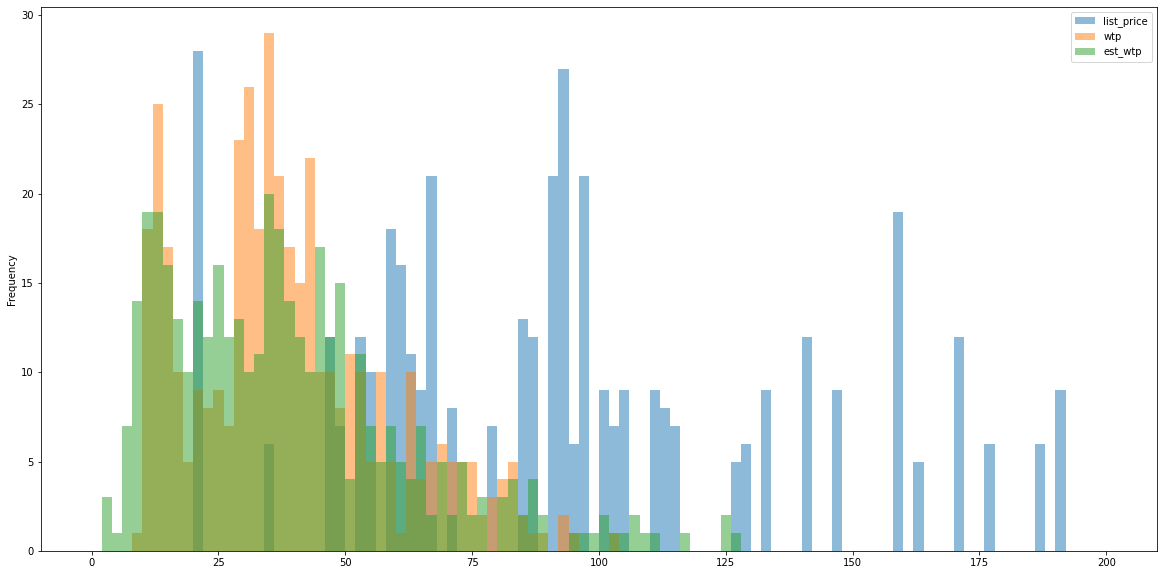

In [248]:
# Distribution of price-like variables
df[['list_price', 'wtp', 'est_wtp']].plot.hist(bins=100, alpha=0.5, figsize=(20,10), range=(0,200))

<AxesSubplot:xlabel='index', ylabel='price'>

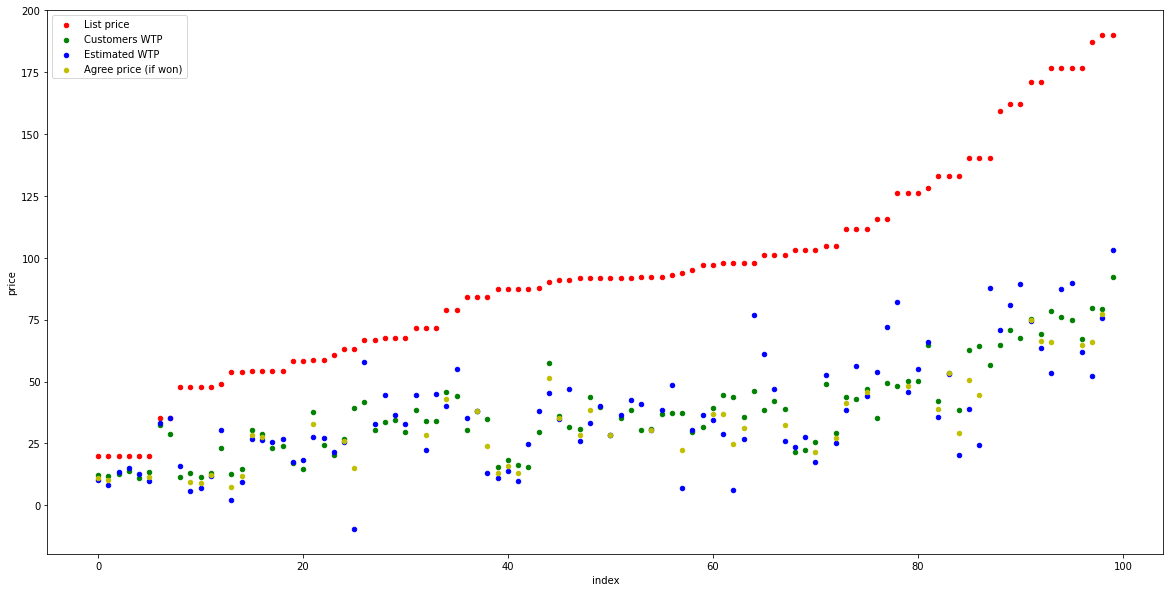

In [249]:
# Prices for random sample of quotes
examples = df.sample(100).sort_values(by='list_price').reset_index(drop=True).reset_index()
ax = examples.plot.scatter(x='index', y='list_price', color='r', label='List price', figsize=(20,10))
examples.plot.scatter(x='index', y='wtp', color='g', label='Customers WTP', ax=ax)
examples.plot.scatter(x='index', y='est_wtp', color='b', label='Estimated WTP', ax=ax)
examples.plot.scatter(x='index', y='price', color='y', label='Agree price (if won)', ax=ax)

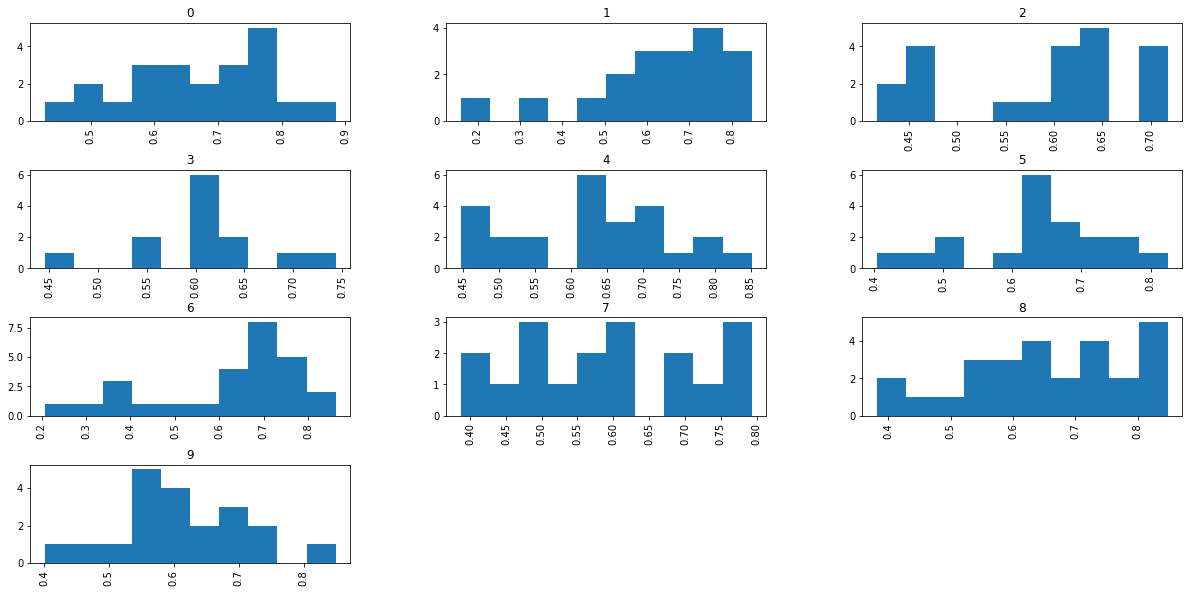

In [250]:
# Distribution of discounts on won deals by salesperson
df['discount'] = np.where(df['result']==1, 1 - df['price']/df['list_price'], np.nan)
_ = df['discount'].hist(by=df['salesperson'], figsize=(20,10))

## Analysis by salesperson

In [ ]:
ss = df.reset_index().groupby('salesperson').agg({'index':'count', 'discount':'mean', 'result':'mean', 'wtp':'sum', 'price':'sum'})